Starting Monte Carlo Simulation...
Simulations: 100000
Locations: 6
Strategies: 6
--------------------------------------------------
Simulating Hotung...
Simulating Tower...
Simulating Hodgedon...
Simulating Kindlevan...
Simulating Dewick...
Simulating Carmichael...

=== AVERAGE DAILY PROFIT MATRIX ($) ===
Strategy             1         2         3         4         5         6
Dining Place                                                            
Carmichael    20581.41  21074.43  21167.42  20398.36  19934.63  21000.20
Dewick        20587.35  21077.35  21167.77  20401.94  19934.27  20998.11
Hodgedon       3417.03   1177.03   2964.72   3319.83   3417.02   3417.02
Hotung        -1905.49  -4005.49  -2008.85  -1908.72  -1905.49  -1905.49
Kindlevan      9458.51  10890.02  10449.79  11090.15   9646.01  11429.82
Tower          3340.76   2692.35   3025.38   3148.87   3205.14   3296.14

=== OPTIMAL STRATEGIES SUMMARY ===
Hotung: Strategy 1 (Profit: $-1,905)
Tower: Strategy 1 (Profit: $3,341)


/var/folders/c5/_85xqcr921j_mqh696p2_qnr0000gn/T/ipykernel_87298/1621842586.py:406: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Strategy", y="Profit", data=df_kindlevan, palette="Set2")


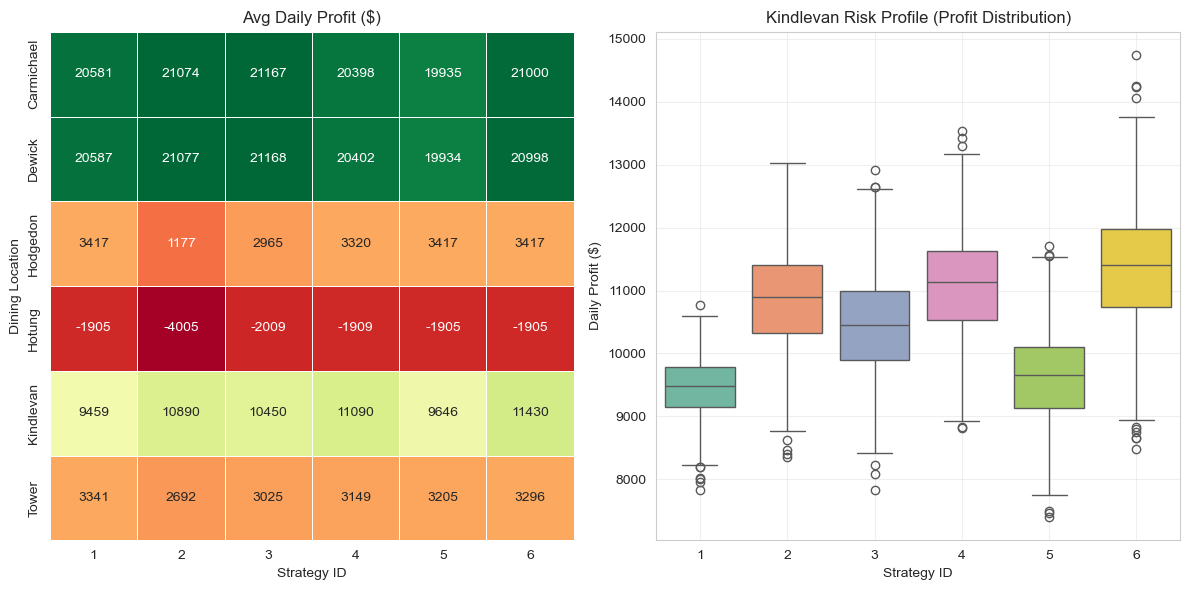

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURATION & CONSTANTS
# ==========================================

NUM_SIMULATIONS = 100000  # As requested in proposal
MEAL_PRICE = 18.0        # Revenue per student
TOTAL_STUDENTS = 13000   # Total population
HOURS_OPEN = 12          # 9AM to 9PM
SLOTS_PER_HOUR = 2       # 30 min slots
TOTAL_SLOTS = HOURS_OPEN * SLOTS_PER_HOUR

# Time slots indices (0 = 9:00AM, 1 = 9:30AM, ... 23 = 8:30PM)
# Rush Hours: Lunch (11:30-1:30 -> slots 5-8), Dinner (5:30-7:00 -> slots 17-19)
RUSH_SLOTS = [5, 6, 7, 8, 17, 18, 19]

# Class Break Slots (Every 3 slots as per Strategy 4)
CLASS_BREAK_SLOTS = [2, 5, 8, 11, 14, 17, 20, 23]

class DiningHall:
    def __init__(self, name, popularity, line_capacity, line_cost, base_cost, class_rush_factor=0.0, operating_hours_mask=None):
        self.name = name
        self.popularity = popularity       # Share of total students (0.0 to 1.0)
        self.line_capacity = line_capacity # Students served per slot per line
        self.line_cost = line_cost         # Cost to open one line for one slot
        self.base_cost = base_cost         # Fixed daily overhead
        self.class_rush_factor = class_rush_factor # Intensity of between-class spikes

        # operating_hours_mask: list of 1s (open) and 0s (closed) for 24 slots
        # Default: Open all 24 slots
        if operating_hours_mask is None:
            self.operating_hours_mask = np.ones(TOTAL_SLOTS)
        else:
            self.operating_hours_mask = np.array(operating_hours_mask)

# ==========================================
# 2. DATA INITIALIZATION (ESTIMATED VALUES)
# ==========================================

# We create a base time profile (Probability of eating at time t)
# Bimodal distribution peaking at Lunch and Dinner
time_t = np.arange(TOTAL_SLOTS)
lunch_peak = np.exp(-(time_t - 7)**2 / 8)  # Peak around 12:30
dinner_peak = np.exp(-(time_t - 18)**2 / 8) # Peak around 6:00
BASE_TIME_PROFILE = (lunch_peak + dinner_peak)
BASE_TIME_PROFILE = BASE_TIME_PROFILE / BASE_TIME_PROFILE.sum() # Normalize

# Define Dining Halls based on proposal descriptions
# Note: "Short hours" for Carmichael/Dewick modeled as closing early or opening late if needed.
# Assuming standard 9-9 for simplicity unless specified.

halls = [
    # Hotung: Less popular, High Cap, High Cost. Moderate class rush.
    DiningHall("Hotung", popularity=0.05, line_capacity=100, line_cost=300, base_cost=1000, class_rush_factor=0.05),

    # Tower: Less popular, Low Cap, Low Cost. Moderate class rush.
    DiningHall("Tower", popularity=0.05, line_capacity=40, line_cost=100, base_cost=500, class_rush_factor=0.05),

    # Hodgedon: Popular, High Cap, High Cost. Mostly mealtime, minor break traffic.
    DiningHall("Hodgedon", popularity=0.1, line_capacity=150, line_cost=320, base_cost=1500, class_rush_factor=0.05),

    # Kindlevan: Popular, Low Cap, Low Cost. HEAVY rush between classes.
    DiningHall("Kindlevan", popularity=0.1, line_capacity=50, line_cost=100, base_cost=800, class_rush_factor=0.10),

    # Dewick: Popular, Very High Cap, High Cost. Sit-down, negligible class rush.
    DiningHall("Dewick", popularity=0.35, line_capacity=150, line_cost=350, base_cost=2000, class_rush_factor=0.01),

    # Carmichael: Popular, Very High Cap, High Cost. Sit-down, negligible class rush.
    DiningHall("Carmichael", popularity=0.35, line_capacity=150, line_cost=350, base_cost=2000, class_rush_factor=0.01)
]

# ==========================================
# 3. SIMULATION ENGINE
# ==========================================

def generate_demand(hall, n_sims):
    """
    Generates a (n_sims x 24) matrix of student arrivals.
    Uses Normal distribution to add noise to the base profile.
    """
    # Base expected students per slot
    # Total Students * Hall Popularity * % eating at time t
    expected_per_slot = TOTAL_STUDENTS * hall.popularity * BASE_TIME_PROFILE

    # Create matrix
    demand_matrix = np.zeros((n_sims, TOTAL_SLOTS))

    for t in range(TOTAL_SLOTS):
        if hall.operating_hours_mask[t] == 0:
            demand_matrix[:, t] = 0
            continue

        mu = expected_per_slot[t]

        # Apply Class Rush Spike
        if t in CLASS_BREAK_SLOTS:
            # Add a spike proportional to the hall's daily population magnitude
            rush_spike = (TOTAL_STUDENTS * hall.popularity) * hall.class_rush_factor
            mu += rush_spike

        sigma = mu * 0.25 # 25% volatility (High volatility as requested for Monte Carlo value)

        # Generate random demand, ensure no negative students
        demand_matrix[:, t] = np.maximum(0, np.random.normal(mu, sigma, n_sims))

    return np.round(demand_matrix)

def run_simulation(hall, strategy_id, demand_matrix):
    """
    Runs the simulation for a specific hall and strategy.
    Returns dictionary with arrays for profit, unmet demand, utilization,
    PLUS detailed time-series matrices for analysis.
    """
    n_sims = demand_matrix.shape[0]
    lines_open = np.zeros((n_sims, TOTAL_SLOTS))

    # --- STRATEGY LOGIC ---

    if strategy_id == 1:
        # 1. Always open 1 line
        lines_open[:] = 1

    elif strategy_id == 2:
        # 2. Open 2 lines during rush hours, 1 otherwise
        lines_open[:] = 1
        lines_open[:, RUSH_SLOTS] = 2

    elif strategy_id == 3:
        # 3. Start 1. Add 1 at rush. Reduce if idle (min 1).
        # "Reduce if idle": We interpret this as checking the *previous* slot.
        # However, Strat 3 implies a reactive intra-day logic or a rule-based logic.
        # Given "Rush Hours" is a fixed time concept, we combine Rule + Reactive.

        # Base rule
        lines_open[:] = 1
        lines_open[:, RUSH_SLOTS] = 2

        # Reactive reduction: We iterate through time.
        # If t-1 was "idle" (demand < capacity of lines-1), reduce lines at t.
        # Note: Vectorizing sequential dependencies requires a loop over t.
        for t in range(1, TOTAL_SLOTS):
            prev_demand = demand_matrix[:, t-1]
            prev_lines = lines_open[:, t-1]
            prev_cap = prev_lines * hall.line_capacity

            # Idle threshold: If demand was less than 40% of capacity
            is_idle = prev_demand < (prev_cap * 0.4)

            # Logic: If it is a rush hour, we want 2, UNLESS it was idle previously.
            # If not rush, we want 1.

            # Reset to base strategy first
            current_base = 2 if t in RUSH_SLOTS else 1

            # Apply reduction logic vectorised
            # If idle and base > 1, reduce to 1.
            # (Simplification of "Reduce lines with min of 1")
            actual_lines = np.where(is_idle & (current_base > 1), current_base - 1, current_base)
            lines_open[:, t] = actual_lines

    elif strategy_id == 4:
        # 4. Always 1, add 1 at class breaks (every 3 slots). Reduce if idle.
        lines_open[:] = 1
        lines_open[:, CLASS_BREAK_SLOTS] = 2

        # Similar idle reduction logic as Strat 3
        for t in range(1, TOTAL_SLOTS):
            prev_demand = demand_matrix[:, t-1]
            prev_lines = lines_open[:, t-1]
            prev_cap = prev_lines * hall.line_capacity
            is_idle = prev_demand < (prev_cap * 0.4)

            current_base = lines_open[:, t] # 2 if class break, 1 otherwise
            actual_lines = np.where(is_idle & (current_base > 1), current_base - 1, current_base)
            lines_open[:, t] = actual_lines

    elif strategy_id == 5:
        # 5. Capacity Trigger: If current lines reach capacity at t-1, open new at t.
        # Start with 1 line at t=0
        lines_open[:, 0] = 1

        for t in range(1, TOTAL_SLOTS):
            prev_lines = lines_open[:, t-1]
            prev_capacity = prev_lines * hall.line_capacity
            prev_demand = demand_matrix[:, t-1]

            # Check if capacity was hit (demand >= 95% of capacity)
            hit_capacity = prev_demand >= (prev_capacity * 0.95)

            # If hit capacity, add line (max 5 lines to prevent infinite growth). Else maintain or drop to 1.
            # Logic: If hit cap -> lines + 1. If very idle ( < 30% cap) -> lines - 1. Else -> same.

            new_lines = prev_lines.copy()
            new_lines[hit_capacity] += 1
            new_lines[~hit_capacity & (prev_demand < prev_capacity * 0.3)] -= 1

            # Clamp between 1 and 5
            new_lines = np.clip(new_lines, 1, 5)
            lines_open[:, t] = new_lines

    elif strategy_id == 6:
        # 6. Review previous day (Oracle / History strategy).
        # Open line if capacity was hit YESTERDAY.
        # We simulate "Yesterday" by creating a separate demand matrix (random variation)
        # identifying the bottlenecks, and setting a fixed schedule for "Today".

        # 1. Simulate Yesterday
        yesterday_demand = generate_demand(hall, n_sims)
        optimized_schedule = np.ones((n_sims, TOTAL_SLOTS))

        # Determine necessary lines for yesterday to meet demand perfectly
        # implied_lines = ceiling(demand / capacity)
        implied_lines = np.ceil(yesterday_demand / hall.line_capacity)

        # Strategy says "Open 1 additional line at time slot when lines are at capacity"
        # We will assume this means we adopt the schedule that would have worked yesterday
        # Clamped to reasonable max (e.g., 4)
        optimized_schedule = np.clip(implied_lines, 1, 4)

        # Reduce if idle logic (from prompt) applied to the plan
        # If a slot requires 3 lines but previous slot required 1, maybe smooth it?
        # For strict adherence to prompt: We just use the schedule derived from history.
        lines_open = optimized_schedule

    # --- CALCULATE METRICS ---

    # Ensure lines are integers
    lines_open = lines_open.astype(int)

    # 1. Costs
    daily_line_costs = np.sum(lines_open * hall.line_cost, axis=1)
    total_costs = daily_line_costs + hall.base_cost

    # 2. Revenue & Service
    total_capacity = lines_open * hall.line_capacity
    students_served = np.minimum(demand_matrix, total_capacity)

    # Closed hours check
    students_served[:, hall.operating_hours_mask == 0] = 0
    total_revenue = np.sum(students_served * MEAL_PRICE, axis=1)

    # 3. Profit
    profit = total_revenue - total_costs

    # 4. Deep Dive Metrics
    # Unmet Demand: Students who wanted to eat but couldn't
    unmet_demand_matrix = demand_matrix - students_served
    daily_unmet = np.sum(unmet_demand_matrix, axis=1)

    # Utilization: Total Served / Total Capacity (Daily Aggregate)
    # Avoid div by zero if capacity is 0 (closed)
    daily_total_cap = np.sum(total_capacity, axis=1)
    daily_total_served = np.sum(students_served, axis=1)

    with np.errstate(divide='ignore', invalid='ignore'):
        daily_utilization = daily_total_served / daily_total_cap
        daily_utilization = np.nan_to_num(daily_utilization) # Replace NaNs with 0

    return {
        "profit": profit,
        "unmet_demand": daily_unmet,
        "utilization": daily_utilization,
        "lines_open_matrix": lines_open,      # Added for detailed tracking
        "served_matrix": students_served      # Added for detailed tracking
    }

# ==========================================
# 4. MAIN EXECUTION LOOP
# ==========================================

print(f"Starting Monte Carlo Simulation...")
print(f"Simulations: {NUM_SIMULATIONS}")
print(f"Locations: {len(halls)}")
print(f"Strategies: 6")
print("-" * 50)

results = []
# We'll store raw data for Kindlevan for boxplotting
kindlevan_data = []

# To store best strategy data for detailed reporting later
best_strategy_details = {}

for hall in halls:
    print(f"Simulating {hall.name}...")

    shared_demand = generate_demand(hall, NUM_SIMULATIONS)

    best_profit_so_far = -np.inf
    best_strat_id = -1

    for strat in range(1, 7):
        sim_out = run_simulation(hall, strat, shared_demand)
        profits = sim_out["profit"]
        unmet = sim_out["unmet_demand"]
        util = sim_out["utilization"]

        avg_profit = np.mean(profits)

        # Track if this is the winning strategy
        if avg_profit > best_profit_so_far:
            best_profit_so_far = avg_profit
            best_strat_id = strat

            # Calculate Hourly Averages for the Winner
            avg_lines_t = np.mean(sim_out["lines_open_matrix"], axis=0)
            avg_served_t = np.mean(sim_out["served_matrix"], axis=0)
            avg_demand_t = np.mean(shared_demand, axis=0)

            best_strategy_details[hall.name] = {
                "Strategy": strat,
                "Avg Profit": avg_profit,
                "Avg Lines Open (Hourly)": avg_lines_t,
                "Avg Served (Hourly)": avg_served_t,
                "Avg Demand (Hourly)": avg_demand_t
            }

        std_profit = np.std(profits)
        avg_unmet = np.mean(unmet)
        avg_util = np.mean(util)

        results.append({
            "Dining Place": hall.name,
            "Strategy": strat,
            "Avg Profit": avg_profit,
            "Std Dev": std_profit,
            "Avg Unmet Demand": avg_unmet,
            "Avg Utilization": avg_util
        })

        if hall.name == "Kindlevan":
            # Store subset of raw data for visualization (to keep memory manageable, store 1000 pts)
            for p in profits[:1000]:
                kindlevan_data.append({"Strategy": strat, "Profit": p})

# ==========================================
# 5. RESULTS & REPORTING
# ==========================================

df_results = pd.DataFrame(results)

# 1. Profit Matrix
pivot_profit = df_results.pivot(index='Dining Place', columns='Strategy', values='Avg Profit')
print("\n=== AVERAGE DAILY PROFIT MATRIX ($) ===")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(pivot_profit.round(2))

# 2. Find Best Strategy
print("\n=== OPTIMAL STRATEGIES SUMMARY ===")
for hall in halls:
    hall_data = df_results[df_results["Dining Place"] == hall.name]
    best_row = hall_data.loc[hall_data["Avg Profit"].idxmax()]
    print(f"{hall.name}: Strategy {int(best_row['Strategy'])} "
          f"(Profit: ${best_row['Avg Profit']:,.0f})")

# 3. Detailed Breakdown for Optimal Strategies
print("\n=== DETAILED ANALYSIS OF OPTIMAL STRATEGIES (AVG DAY) ===")
for hall in halls:
    details = best_strategy_details[hall.name]
    print(f"\n>> {hall.name} using Best Strategy ({details['Strategy']})")

    # Create a clean hourly dataframe for display
    # We aggregate 30-min slots into Hours for cleaner reading, or show key slots
    # Showing simplified table for Key Times: 9:00, 12:30 (Lunch), 15:00, 18:00 (Dinner)

    lines_sched = details["Avg Lines Open (Hourly)"]
    demand_sched = details["Avg Demand (Hourly)"]
    served_sched = details["Avg Served (Hourly)"]
    unmet_sched = demand_sched - served_sched

    # Create DataFrame for all 24 slots
    times = [f"{9 + i//2:02d}:{'00' if i%2==0 else '30'}" for i in range(TOTAL_SLOTS)]
    df_day = pd.DataFrame({
        "Time": times,
        "Demand": demand_sched,
        "Lines": lines_sched,
        "Served": served_sched,
        "Unmet": unmet_sched
    })

    # Print simplified view (every 4th slot -> Every 2 hours, plus peaks)
    # Indices: 0(9am), 5(11:30), 7(12:30), 12(3pm), 18(6pm), 23(8:30pm)
    indices_to_show = [0, 5, 7, 12, 18, 23]
    print(df_day.iloc[indices_to_show].round(1).to_string(index=False))

    print(f"Avg Max Lines Open: {np.max(lines_sched):.1f}")
    print(f"Total Daily Unmet: {np.sum(unmet_sched):.1f}")


# Visualization: Heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(pivot_profit, annot=True, fmt=".0f", cmap="RdYlGn", linewidths=.5, cbar=False)
plt.title("Avg Daily Profit ($)")
plt.ylabel("Dining Location")
plt.xlabel("Strategy ID")

# Visualization: Kindlevan Risk Profile
df_kindlevan = pd.DataFrame(kindlevan_data)
plt.subplot(1, 2, 2)
sns.boxplot(x="Strategy", y="Profit", data=df_kindlevan, palette="Set2")
plt.title("Kindlevan Risk Profile (Profit Distribution)")
plt.ylabel("Daily Profit ($)")
plt.xlabel("Strategy ID")
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('dining_analysis.png')
print("\nSimulation Complete.")